# Simples reconhecimento de áudios: reconhecendo palavras

Este tutorial demonstra como pré-processar arquivos de áudio no formato WAV e construir e treinar um modelo básico de reconhecimento automático de fala (ASR) para reconhecer dez palavras diferentes. Você usará uma parte do conjunto de dados Comandos de fala ( Warden, 2018 ), que contém clipes de áudio curtos (um segundo ou menos) de comandos, como "para baixo", "ir", "esquerda", "não", " direita", "parar", "para cima" e "sim".

Os sistemas de reconhecimento de voz e áudio do mundo real são complexos. Mas, assim como a classificação de imagens com o conjunto de dados MNIST , este tutorial deve fornecer uma compreensão básica das técnicas envolvidas.

<br>

Importe os módulos e dependências necessários

In [171]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

<br>

# Seção 1: Importar o conjunto de dados mini Speech Commands

Para economizar tempo com o carregamento de dados, será trabalho com uma versão menor do conjunto de dados de Comandos de Fala. O conjunto de dados original consiste em mais de 105.000 arquivos de áudio no formato de arquivo de áudio WAV (Waveform) de pessoas dizendo 35 palavras diferentes. Esses dados foram coletados pelo Google e liberados sob uma licença CC BY.

<br>

Passo 1: Baixe e extraia o arquivo mini_speech_commands.zip contendo os conjuntos de dados menores de Comandos de Fala com tf.keras.utils.get_file :

In [172]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

<br>

Os clipes de áudio do conjunto de dados são armazenados em oito pastas correspondentes a cada comando de fala: `no`, `yes`, `down`, `go`, `left`, `up`, `right` e `stop`:

In [173]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


<br>

Passo 2: Extraia os clipes de áudio em uma lista chamada `filenames` e embaralhe-a:

In [174]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\right\\179a61b7_nohash_4.wav', shape=(), dtype=string)


<br>

Passo 3: Divida `filenames` em treinamento, validação e teste usando uma proporção 80:10:20, respectivamente:

In [175]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


<br><br>

# Seção 2: Leia os arquivos de áudio e seus rótulos

Nesta seção os dados serão pré-processados criando tensores decodificados para as formas de onda e os rótulos correspondentes. Observe que:

 - Cada arquivo WAV contém dados de séries temporais com um número definido de amostras por segundo;
 - Cada amostra representa a amplitude do sinal de áudio naquele momento específico;
 - Em um sistema de 16 bits como os arquivos WAV no conjunto de dados mini Speech Commands, os valores de amplitude variam de -32.768 a 32.767;
 - A taxa de amostragem para este conjunto de dados é de 16kHz.

<br>

Passo 1: A forma do tensor retornado por `tf.audio.decode_wav` é `[samples, channels]`, onde `channels` é `1` para mono ou `2` para estéreo. O conjunto de dados mini Speech Commands contém apenas gravações mono.

In [176]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

<br>

Passo 2: Agora, defini-se uma função que pré-processa os arquivos de áudio WAV brutos do conjunto de dados em tensores de áudio:

In [177]:
def decode_audio( audio_binary ):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

<br>

Passo 3: Define-se uma função que cria rótulos usando os diretórios pai para cada arquivo:

 - Divida os caminhos de arquivo em `tf.RaggedTensor` s (tensores com dimensões irregulares — com fatias que podem ter comprimentos diferentes).

In [178]:
def get_label( file_path ):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

<br>

Passo 4: Defina outra função auxiliar — `get_waveform_and_label` que junte tudo:

 - A entrada é o nome do arquivo de áudio WAV.
 - A saída é uma tupla contendo os tensores de áudio e rótulo prontos para aprendizado supervisionado.

In [179]:
def get_waveform_and_label( file_path ):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

<br>

Passo 5: Crie o conjunto de treinamento para extrair os pares de rótulo de áudio:


- Crie um `tf.data.Dataset` com `Dataset.from_tensor_slices` e `Dataset.map`, usando `get_waveform_and_label` definido anteriormente.

Os conjuntos de validação e teste serão construídos usando um procedimento semelhante posteriormente.

In [180]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

<br>

Visualizando algumas formas de áudios:

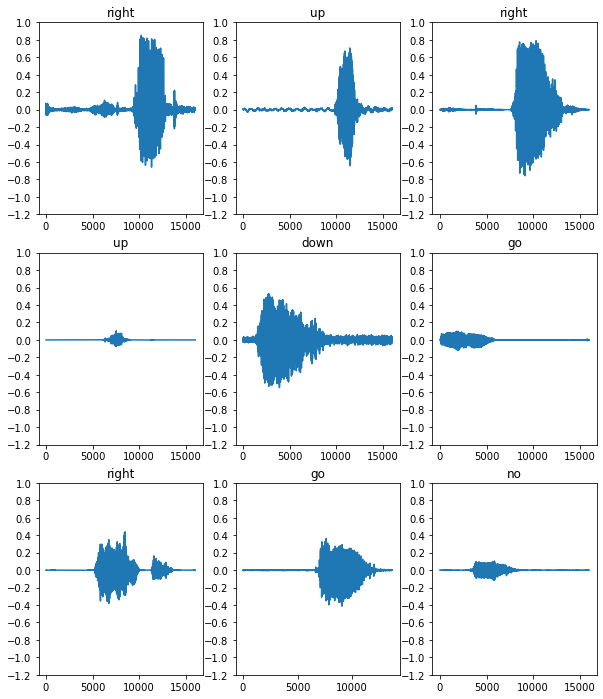

In [181]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

<br>

# Seção 3: Converter formas de onda em espectrogramas

As formas de onda no conjunto de dados são representadas no domínio do tempo. Em seguida, as formas de onda dos sinais no domínio do tempo serão transformadas em sinais no domínio da frequência do tempo calculando a transformada de Fourier de curta duração (STFT) para converter as formas de onda em espectrogramas, que mostram mudanças de frequência ao longo do tempo e podem ser representados como imagens 2D. As imagens do espectrograma irão alimentar a rede neural para treinar o modelo.

Uma transformada de Fourier ( tf.signal.fft ) converte um sinal para suas frequências componentes, mas perde todas as informações de tempo. Em comparação, STFT ( tf.signal.stft ) divide o sinal em janelas de tempo e executa uma transformada de Fourier em cada janela, preservando algumas informações de tempo e retornando um tensor 2D no qual pode-se executar convoluções padrão.

<br>

Passo 1: Criar uma função utilitária para converter formas de onda em espectrogramas:

 - As formas de onda precisam ter o mesmo comprimento, para que, ao convertê-las em espectrogramas, os resultados tenham dimensões semelhantes. Isso pode ser feito simplesmente zerando os clipes de áudio com menos de um segundo (usando tf.zeros ).
 - Ao chamar tf.signal.stft, escolhe-se os parâmetros frame_length e frame_step de forma que a "imagem" do espectrograma gerado seja quase quadrada. 
 - A STFT produz uma matriz de números complexos representando magnitude e fase. No entanto, neste tutorial será usada apenas a magnitude, que pode ser derivada aplicando tf.abs na saída de tf.signal.stft.

In [182]:
def get_spectrogram( waveform ):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

<br>

Passo 2: comece a explorar os dados. Imprima as formas da forma de onda tensorizada de um exemplo e o espectrograma correspondente e reproduza o áudio original:

In [183]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


<br>

Passo 3: Agora, define-se uma função para exibir um espectrograma:

In [184]:
def plot_spectrogram( spectrogram, ax ):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<br>

Passo 4: Plote a forma de onda do exemplo ao longo do tempo e o espectrograma correspondente (frequências ao longo do tempo):

<ipython-input-184-7d9187ba7e19>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


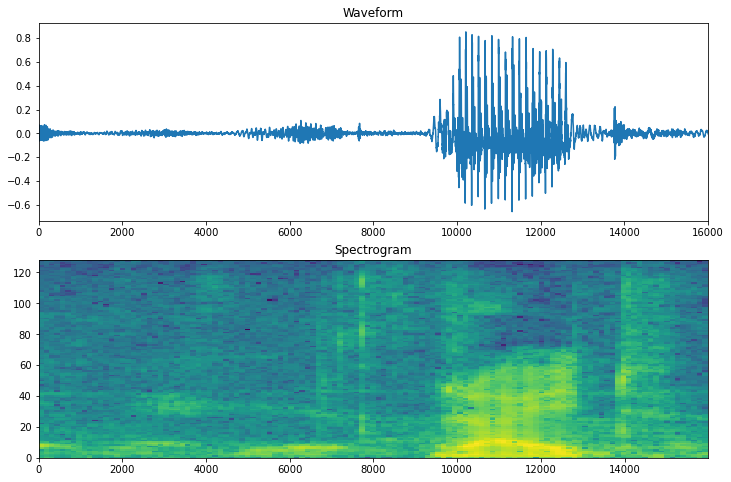

In [185]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

<br>

Passo 5: Agora, defina uma função que transforma o conjunto de dados da forma de onda em espectrogramas e seus rótulos correspondentes como IDs inteiros:

In [186]:
def get_spectrogram_and_label_id( audio, label ):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

<br>

Passo 6: Mapeie get_spectrogram_and_label_id entre os elementos do conjunto de dados com Dataset.map:

In [187]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

<br>

Passo 7: Examine os espectrogramas para diferentes exemplos do conjunto de dados:

<ipython-input-184-7d9187ba7e19>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


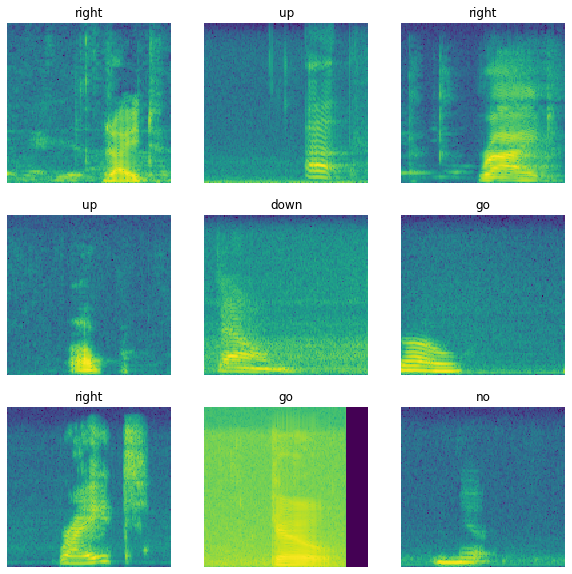

In [188]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

<br><br>

# Seção 4: Construir e treinar o modelo

Repita o pré-processamento do conjunto de treinamento nos conjuntos de validação e teste:

In [189]:
def preprocess_dataset( files ):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [190]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

<br>

Passo 1: Agrupe os conjuntos de treinamento e validação para treinamento de modelo:

In [191]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

<br>

Passo 2: Adicione as operações Dataset.cache e Dataset.prefetch para reduzir a latência de leitura durante o treinamento do modelo:

In [192]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

<br>

Passo 3: Para o modelo, será usado uma rede neural convolucional simples (CNN), pois transformou os arquivos de áudio em imagens de espectrograma.

O modelo tf.keras.Sequential usará as seguintes camadas de pré-processamento Keras:

 - tf.keras.layers.Resizing: para reduzir a amostra da entrada para permitir que o modelo treine mais rápido.
 - tf.keras.layers.Normalization: para normalizar cada pixel da imagem com base em sua média e desvio padrão.


Para a camada de Normalization, seu método de adapt precisaria primeiro ser chamado nos dados de treinamento para calcular estatísticas agregadas (ou seja, a média e o desvio padrão).

In [193]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024, activation='relu', bias_initializer='zeros'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', bias_initializer='zeros'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', bias_initializer='zeros'),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)      

<br>

Passo 4: Configure o modelo Keras com o otimizador Adam e a perda de entropia cruzada:

In [194]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

<br>

Passo 5: Treinamento com algumas épocas

In [195]:
EPOCHS = 300
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    use_multiprocessing=True,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/300
200/200 [==============================] - 36s 176ms/step - loss: 1.8975 - accuracy: 0.2919 - val_loss: 1.5232 - val_accuracy: 0.5000
Epoch 2/300
200/200 [==============================] - 33s 166ms/step - loss: 1.4145 - accuracy: 0.5066 - val_loss: 1.1283 - val_accuracy: 0.6200
Epoch 3/300
200/200 [==============================] - 33s 166ms/step - loss: 1.0816 - accuracy: 0.6142 - val_loss: 0.8949 - val_accuracy: 0.6687
Epoch 4/300
200/200 [==============================] - 33s 166ms/step - loss: 0.8746 - accuracy: 0.6769 - val_loss: 0.8069 - val_accuracy: 0.7075
Epoch 5/300
200/200 [==============================] - 33s 166ms/step - loss: 0.7452 - accuracy: 0.7330 - val_loss: 0.7442 - val_accuracy: 0.7325
Epoch 6/300
200/200 [==============================] - 33s 166ms/step - loss: 0.6420 - accuracy: 0.7616 - val_loss: 0.6690 - val_accuracy: 0.7663
Epoch 7/300
200/200 [==============================] - 33s 166ms/step - loss: 0.5630 - accuracy: 0.7930 - val_loss: 0.5917 -

<br>

Passo 6: Vamos plotar as curvas de perda de treinamento e validação para verificar como seu modelo melhorou durante o treinamento:

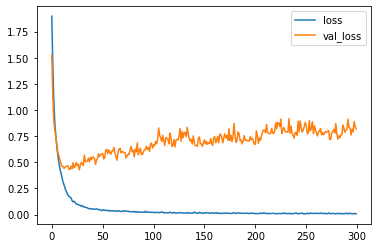

In [196]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

<br><br>

# Seção 5: Evolua a performance do modelo

<br>

Passo 1: Execute o modelo no conjunto de teste e verifique o desempenho do modelo:

In [197]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [198]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


<br>

Passo 2: Exibir uma matriz de confusão

Use uma matriz de confusão para verificar quão bem o modelo classificou cada um dos comandos no conjunto de teste:

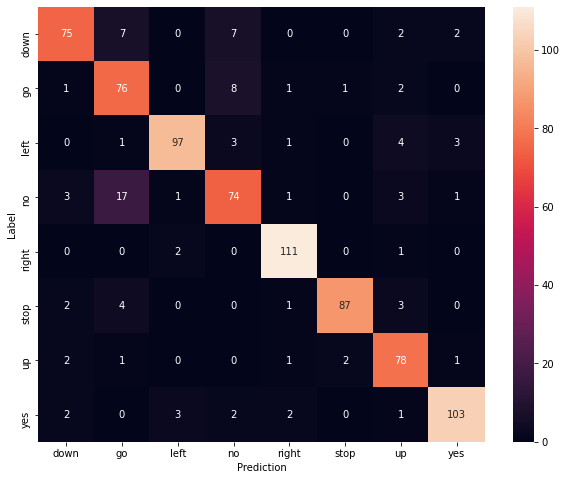

In [199]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

<br><br>

# Seção 6: Executar inferência em um arquivo de áudio

Passo 1: Por fim, verifique a saída de previsão do modelo usando um arquivo de áudio de entrada de alguém dizendo "não". Qual é o desempenho do seu modelo?

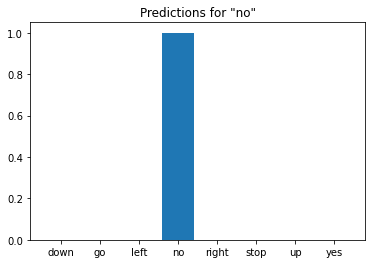

In [200]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

Como a saída sugere, seu modelo deve ter reconhecido o comando de áudio como "não".

<br><br><br>

# Próximos passos

Este tutorial demonstrou como realizar classificação de áudio simples/reconhecimento automático de fala usando uma rede neural convolucional com TensorFlow e Python. Para saber mais, considere os seguintes recursos:

O tutorial Classificação de som com YAMNet mostra como usar o aprendizado de transferência para classificação de áudio.
Os notebooks do desafio de reconhecimento de fala TensorFlow da Kaggle .
O TensorFlow.js - Reconhecimento de áudio usando codelab de aprendizado de transferência ensina como criar seu próprio aplicativo da Web interativo para classificação de áudio.
Um tutorial sobre aprendizado profundo para recuperação de informações musicais (Choi et al., 2017) no arXiv.
O TensorFlow também tem suporte adicional para preparação e aumento de dados de áudio para ajudar em seus próprios projetos baseados em áudio.
Considere usar a biblioteca librosa —um pacote Python para análise de música e áudio.